# Import libraries and dataset

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split

# Import Datasets
df = pd.read_csv('/Users/samlai/Documents/Vehicle_insurance_claim_project/data/raw/fraud_oracle.csv')
df.shape

(15420, 33)

In [132]:
# Drop ID Column
df = df.drop(columns = ['PolicyNumber'])

# change data type
df['RepNumber'] = df['RepNumber'].astype('category')
df['WeekOfMonth'] = df['WeekOfMonth'].astype('category')
df['WeekOfMonthClaimed'] = df['WeekOfMonthClaimed'].astype('category')
df['Deductible'] = df['Deductible'].astype('category')
df['Year'] = df['Year'].astype('category')
df['DriverRating'] = df['DriverRating'].astype('category') 

# 將特徵分組

In [133]:
# 保險人特徵
policyholder_feature = [
    'Sex', 'Age', 'DriverRating', 'AgeOfPolicyHolder', 'AddressChange_Claim',
    'NumberOfCars','PastNumberOfClaims', 'MaritalStatus'
]

# 車禍事件特徵 
accident_feature = [
    'AccidentArea', 'Fault', 'PoliceReportFiled', 'NumberOfSuppliments', 'Days_Policy_Accident', 
    'Days_Policy_Claim', 'BasePolicy', 'Deductible', 'PolicyType', 'WitnessPresent'
]

# 車輛特徵
vehicle_feature = [
    'AgeOfVehicle', 'VehiclePrice', 'Make', 'VehicleCategory'
]

# 時間特徵
time_feature = [
    'Month', 'WeekOfMonth', 'DayOfWeek', 'Year', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed'
]

# 其他特徵
other_feature = [
    'AgentType', 'RepNumber'
]

Target = ['FraudFound_P']


In [134]:
# 檢查是否有特徵未被分組
all_grouped_features = policyholder_feature + accident_feature + vehicle_feature + time_feature + other_feature
all_features = df.columns.tolist()


ungrouped_features = [f for f in all_features if f not in all_grouped_features]
if ungrouped_features:
    print("未分組的特徵:")
    for f in ungrouped_features:
        print(f)
else:
    print("所有特徵都已被分組")

未分組的特徵:
FraudFound_P


In [136]:
df_policyholder = df[policyholder_feature]
df_accident = df[accident_feature]
df_vehicle = df[vehicle_feature]
df_time = df[time_feature]
df_other = df[other_feature]
df_target = df[Target]

# Create a Function to evaluate created features

In [137]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate the accuracy, precision, recall, and F1 score
def get_test_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')

    # Calculate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label') 
    plt.show()

In [138]:
# Concatenate all feature dataframes and target variable horizontally
def model_test(df_policyholder, df_accident, df_vehicle, df_time, df_other, df_target):
    df_new = pd.concat([df_policyholder, df_accident, df_vehicle, df_time, df_other, df_target], axis=1)
    X = df_new.drop(columns = ['FraudFound_P'])
    y = df_new['FraudFound_P']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    # Train a Balanced Bagging Classifier (base model: LGBM)
    import lightgbm as lgb
    from imblearn.ensemble import BalancedBaggingClassifier

    lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
    balbag = BalancedBaggingClassifier(estimator = lgbm, n_estimators=100, bootstrap = True,
                                    bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                    n_jobs = -1, random_state = 42)

    balbag.fit(X_train, y_train)
    y_pred = balbag.predict(X_test)
    y_prob = balbag.predict_proba(X_test)[:, 1]

    get_test_metrics(y_test, y_pred, y_prob)

# 將Age分群 (結論：已有 'AgeOfPolicyHolder'，刪除Age)

In [139]:
df_policyholder_dropAge = df_policyholder.drop(columns = 'Age')
model_test(df_policyholder_dropAge, df_accident, df_vehicle, df_time, df_other, df_target)

ValueError: could not convert string to float: 'Sedan - Liability'

In [110]:
df_policyholder = df_policyholder.drop(columns = 'Age')

# 創造高風險車子品牌標籤特徵 (結論：保留新建的高風險特徵，移除所有Brand Make特徵)

In [112]:
# Create HighRisk_brand feature based on specific makes
# Mecedes, BMW, Saab, Saturn, BMW, Ford, Mercury 這些為高風險品牌
# Accurca 是One-hot Encoding後的基準類別，其他 Make features若皆為 0 就是Accurca
high_risk_makes = ['Make_Mecedes', 'Make_Saab', 'Make_Saturn', 'Make_BMW', 'Make_Ford', 'Make_Mercury']

# Get all make columns
all_makes = ['Make_Chevrolet', 'Make_Ford', 'Make_Honda', 'Make_Mazda', 'Make_Pontiac', 
            'Make_Toyota', 'Make_VW', 'Make_BMW', 'Make_Dodge', 'Make_Ferrari', 
            'Make_Jaguar', 'Make_Lexus', 'Make_Mecedes', 'Make_Mercury', 'Make_Nisson',
            'Make_Porche', 'Make_Saab', 'Make_Saturn']

# Create HighRisk_brand feature
df_vehicle['HighRisk_brand'] = ((df_vehicle[high_risk_makes].any(axis=1)) | 
                               (df_vehicle[all_makes].sum(axis=1) == 0)).astype(int)


/var/folders/th/klmxbc1d2x58bny86xqxsjqc0000gn/T/ipykernel_3767/796372678.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vehicle['HighRisk_brand'] = ((df_vehicle[high_risk_makes].any(axis=1)) |


Accuracy: 0.7127
Precision: 0.1512
Recall: 0.8216
F1 Score: 0.2555
AUC: 0.8375


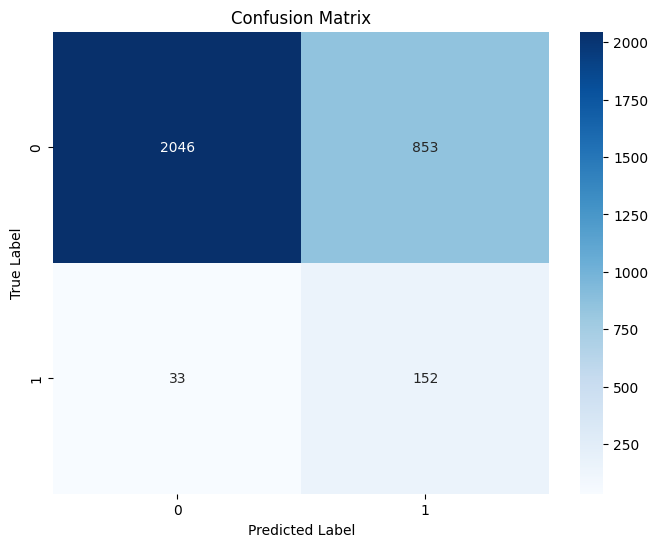

In [119]:
model_test(df_policyholder, df_accident, df_vehicle, df_time, df_other, df_target)

Accuracy: 0.7160
Precision: 0.1535
Recall: 0.8270
F1 Score: 0.2589
AUC: 0.8371


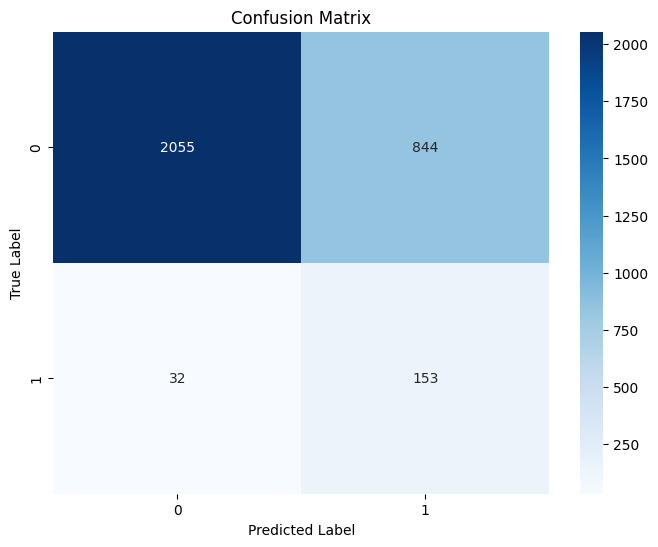

In [120]:
# 成效下降了，試著把Make相關features都刪掉，因為有HighRisk_brand了
df_vehicle_withoutMake = df_vehicle.drop(columns = all_makes)
model_test(df_policyholder, df_accident, df_vehicle_withoutMake, df_time, df_other, df_target)

將18個Brand Make相關feature都刪除後，recall跟F1 score反而有些為提升，表示一個HighRisk_brand就可以提供足夠資訊

In [123]:
# 更新df_vehicle，移除 Brand Make 相關欄位
df_vehicle = df_vehicle.drop(columns = all_makes)

In [126]:
df_vehicle.head()

,AgeOfVehicle,VehiclePrice_30000 to 39000,VehiclePrice_40000 to 59000,VehiclePrice_less than 20000,VehiclePrice_60000 to 69000,VehiclePrice_more than 69000,VehicleCategory_Sport,VehicleCategory_Utility,HighRisk_brand
0,2,False,False,False,False,True,True,False,0
1,5,False,False,False,False,True,True,False,0
2,6,False,False,False,False,True,True,False,0
3,7,False,False,False,False,False,True,False,0
4,4,False,False,False,False,True,True,False,0
